#Import Libraries 

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import librosa.display
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras.callbacks import EarlyStopping

#Dataset

##Downloading

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

In [ ]:
!unzip /content/toronto-emotional-speech-set-tess.zip

##Extract Features

In [ ]:
def getTheSpectrogram(y):
  D = librosa.stft(y)  
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
  return S_db

In [ ]:
def manipulate(data, noise_factor = 0.001):
    """
      This method is used to augment the dataset 
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [ ]:
folder_path = '/content/TESS Toronto emotional speech set data'

In [ ]:
MAX_LENGTH = 61952 #The length of the longest audio clip
X = []
labels = []
for dir_path, _, file_names in os.walk(folder_path):
  for file in file_names:
    if file[-3:] == 'wav':
      wavPath = os.path.join(dir_path,file)
      y,_ = librosa.load(wavPath) #Load the wav file into array
      clip = librosa.effects.trim(y, top_db= 20) #Cutoff all sounds that are less than 20 dB (Silence Duration)
      clip = librosa.util.fix_length(clip[0], size=MAX_LENGTH) #Uniforming all clips to MAX_LENGTH 
      spectrogramArray = getTheSpectrogram(clip) #Get the features from the raw audio 
      X.append(spectrogramArray)
      augmentedSpectrogramArray = getTheSpectrogram(manipulate(clip)) #Do the augmentation
      X.append(augmentedSpectrogramArray)
      labels.append(file.split('_')[-1][:-4]) #Appending the label
      labels.append(file.split('_')[-1][:-4])

In [ ]:
y_ = np.unique(labels, return_inverse=True)[1]

In [ ]:
y_ = to_categorical(y_)

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(np.array(X), y_, test_size=0.20, random_state=1)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>=0.96):
      print("\nReached 96.0% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

#Model

In [ ]:
i1 = Input(shape=(X_train.shape[1],X_train.shape[2]))
x1 = BatchNormalization()(i1)
x1 = Conv1D(128, kernel_size=10,strides=1,activation='relu',padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling1D(2)(x1)
x1 = LSTM(256,activation='tanh')(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Flatten()(x1)
output = Dense(y_train.shape[1], activation='softmax')(x1)
model = Model(inputs=i1, outputs=output)# summarize layers
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1025, 122)]       0         
                                                                 
 batch_normalization_3 (Batc  (None, 1025, 122)        488       
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 1025, 128)         156288    
                                                                 
 batch_normalization_4 (Batc  (None, 1025, 128)        512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 512, 128)         0         
 1D)                                                             
                                                             

In [ ]:
h = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=500, batch_size=64,verbose=1,callbacks=[callbacks])

Epoch 1/500
70/70 [==============================] - 21s 100ms/step - loss: 2.0337 - accuracy: 0.2067 - val_loss: 2.1662 - val_accuracy: 0.1509
Epoch 2/500
70/70 [==============================] - 6s 84ms/step - loss: 1.9095 - accuracy: 0.2156 - val_loss: 2.1044 - val_accuracy: 0.1411
Epoch 3/500
70/70 [==============================] - 6s 84ms/step - loss: 1.8650 - accuracy: 0.2270 - val_loss: 2.1596 - val_accuracy: 0.0991
Epoch 4/500
70/70 [==============================] - 6s 85ms/step - loss: 1.8227 - accuracy: 0.2373 - val_loss: 1.9840 - val_accuracy: 0.1571
Epoch 5/500
70/70 [==============================] - 6s 85ms/step - loss: 1.7143 - accuracy: 0.2891 - val_loss: 1.7118 - val_accuracy: 0.2982
Epoch 6/500
70/70 [==============================] - 6s 85ms/step - loss: 1.6294 - accuracy: 0.3096 - val_loss: 1.5852 - val_accuracy: 0.3250
Epoch 7/500
70/70 [==============================] - 6s 86ms/step - loss: 1.5563 - accuracy: 0.3382 - val_loss: 1.5155 - val_accuracy: 0.3670
Epoc

##Accuracy when the training dataset size is 20% and the batch is 64

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       173
           1       0.94      0.96      0.95       153
           2       0.98      1.00      0.99       164
           3       0.99      0.89      0.93       157
           4       0.97      0.98      0.97       153
           5       0.88      0.98      0.93       164
           6       0.99      0.94      0.97       156

    accuracy                           0.96      1120
   macro avg       0.96      0.96      0.96      1120
weighted avg       0.96      0.96      0.96      1120



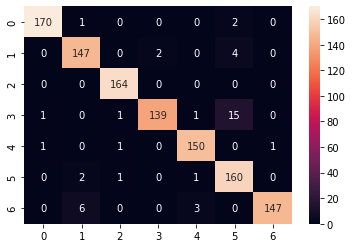

In [ ]:
pred = model.predict(X_test)
Y_pred = np.argmax(pred,axis=1)
Y_test_ = np.argmax(y_test,axis = 1)
print(metrics.classification_report(Y_test_, Y_pred))
sns.heatmap(confusion_matrix(Y_test_,Y_pred), annot=True,fmt='g')

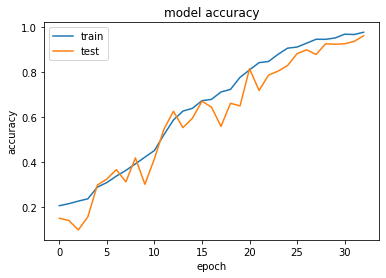

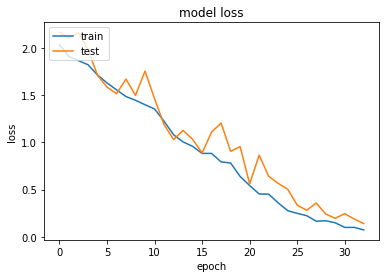

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Accuracy when the training dataset size is 15% and the batch is 128

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       133
           1       0.85      0.96      0.90       117
           2       0.94      0.95      0.95       121
           3       0.87      0.91      0.89       117
           4       0.92      0.93      0.92       105
           5       0.93      0.83      0.88       129
           6       0.96      0.97      0.96       118

    accuracy                           0.92       840
   macro avg       0.92      0.92      0.92       840
weighted avg       0.92      0.92      0.92       840



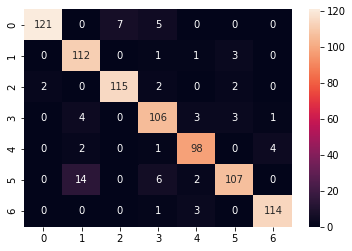

In [ ]:
pred = model.predict(X_test)
Y_pred = np.argmax(pred,axis=1)
Y_test_ = np.argmax(y_test,axis = 1)
print(metrics.classification_report(Y_test_, Y_pred))
sns.heatmap(confusion_matrix(Y_test_,Y_pred), annot=True,fmt='g')

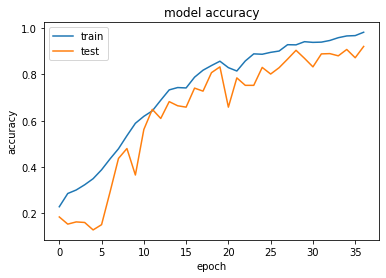

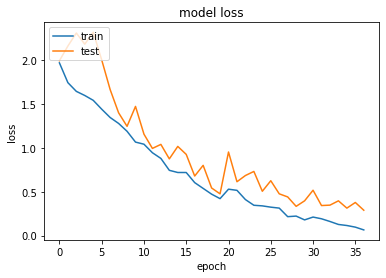

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()